In [1]:
import cv2
import numpy as np
from openvino.runtime import Core

# Đường dẫn đến các tệp .xml và .bin
model_xml = "openvino_notebooks/notebooks/yolov7-optimization/yolov7/model/yolov7-tiny.bin"
model_bin = "openvino_notebooks/notebooks/yolov7-optimization/yolov7/model/yolov7-tiny.xml"

# Load Inference Engine
ie = Core()

# Đọc mô hình từ các tệp .xml và .bin
model = ie.read_model(model=model_xml, weights=model_bin)

# Tải mô hình lên thiết bị (CPU, GPU, MYRIAD, etc.)
compiled_model = ie.compile_model(model=model, device_name="CPU")




RuntimeError: Exception from src/inference/src/cpp/core.cpp:90:
Exception from src/inference/src/model_reader.cpp:160:
Unable to read the model: openvino_notebooks/notebooks/yolov7-optimization/yolov7/model/yolov7-tiny.bin Please check that model format: bin is supported and the model is correct. Available frontends: ir onnx paddle pytorch tf tflite 



In [2]:
from pathlib import Path

if not Path("yolov7").exists():
    !git clone https://github.com/WongKinYiu/yolov7
%cd yolov7

C:\Users\admin\openvino_notebooks\notebooks\yolov7-optimization\yolov7


In [3]:
import numpy as np
import torch
from PIL import Image
from utils.datasets import letterbox
from utils.plots import plot_one_box


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv7 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]

    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv7 input requirements.
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range

    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv7 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


# label names for visualization
DEFAULT_NAMES = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

# obtain class names from model checkpoint
state_dict = torch.load("model/yolov7-tiny.pt", map_location="cpu")
if hasattr(state_dict["model"], "module"):
    NAMES = getattr(state_dict["model"].module, "names", DEFAULT_NAMES)
else:
    NAMES = getattr(state_dict["model"], "names", DEFAULT_NAMES)

del state_dict

# colors for visualization
COLORS = {name: [np.random.randint(0, 255) for _ in range(3)] for i, name in enumerate(NAMES)}

In [5]:
import openvino as ov

In [6]:
from typing import List, Tuple, Dict
from utils.general import scale_coords, non_max_suppression


def detect(
    model: ov.Model,
    image_path: Path,
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
    classes: List[int] = None,
    agnostic_nms: bool = False,
):
    """
   
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for remloving objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    if isinstance(image_path, np.ndarray):
        img = image_path
    else:
        img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[output_blob])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(
    predictions: np.ndarray,
    input_shape: Tuple[int],
    image: np.ndarray,
    names: List[str],
    colors: Dict[str, int],
):
    """
    
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f"{names[int(cls)]} {conf:.2f}"
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

In [7]:
from openvino.runtime import Core
core = ov.Core()
# read converted model
model = core.read_model("model/yolov7-tiny.xml")

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [9]:
compiled_model = core.compile_model(model, device.value)

In [10]:
import collections
import time
from IPython import display
import cv2
from notebook_utils import VideoPlayer

# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model= "model/yolov7-tiny_int8.xml",
    device=device.value,
):
    player = None
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections, _, input_shape = detect(compiled_model, input_image[:, :, ::-1])
            stop_time = time.time()

            image_with_boxes = draw_boxes(detections[0], input_shape, input_image, NAMES, COLORS)
            frame = image_with_boxes

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.⬆️
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

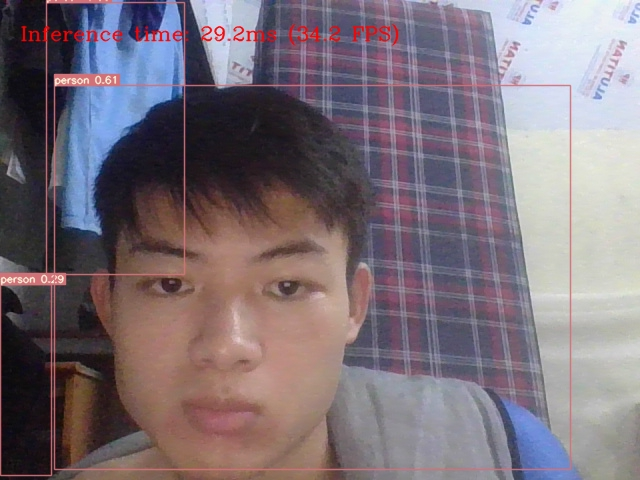

Interrupted


In [11]:
WEBCAM_INFERENCE = True


run_object_detection(
    source=0,
    flip=True,
    use_popup=False,
    model= "model/yolov7-tiny_int8.xml",
    device=device.value,
)
